# Homework 2:  Regression Analysis Using Supervised Learning
### Sean Olson

In [3]:
## Import Libraries
# import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from scipy.stats import skew

%matplotlib inline

# import statistical visualization library
import seaborn as sns

# import supervised learning libraries
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE, RFECV

# import regression libraries
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix, classification_report, roc_auc_score, roc_curve

# suppress warnings
pd.options.mode.chained_assignment = None
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [5]:
# Load data into pandas dataframe

data = pd.read_excel('/Users/seanolson/OneDrive/Documents/UNC Chapel Hill/Kenan-Flagler Business School/KFBS Courses/MBA706 Data Analytics/Week 2/Customer+Transaction+Data.xlsx', sheet_name = 'Data')
print(data.head())

   custid  month   purchase channel_purchase  spend  items  discount_availed  \
0       1       1         0              NaN    NaN    NaN               NaN   
1       1       2         1            Store  347.9    6.0               0.0   
2       1       3         1              Web    6.0    1.0               0.0   
3       1       4         0              NaN    NaN    NaN               NaN   
4       1       5         0              NaN    NaN    NaN               NaN   

   product_return  month_elapsed  catalog_sent  coupon_sent  items_todate  \
0             NaN              0             0            0             0   
1             1.0              1             1            0             0   
2             0.0              0             1            0             6   
3             NaN              0             1            0             7   
4             NaN              1             1            1             7   

   spend_todate  
0           0.0  
1           0.0  
2 

In [6]:
# check on missing values per column
print("Check Nulls - Main Dataframe")
print("----------------------------")
print(data.isnull().sum())

Check Nulls - Main Dataframe
----------------------------
custid                 0
month                  0
purchase               0
channel_purchase    1294
spend               1294
items               1294
discount_availed    1294
product_return      1294
month_elapsed          0
catalog_sent           0
coupon_sent            0
items_todate           0
spend_todate           0
dtype: int64


## Logistic Regresion Question A:  Decision to Purchase

#### First thing is to create binary variables from the Categorical Variable *channel_purchase*, then fill in the rest of the missing data with 0s if no purchase was done

In [7]:
# create binary variables
log1_data = data.copy()

# create empty columns
log1_data['catalog'] = np.nan
log1_data['store'] = np.nan
log1_data['web'] = np.nan

# fill columns with binary outcome
for i in range(0, len(log1_data)):
    if log1_data['channel_purchase'][i] == 'Catalog':
        log1_data['catalog'][i] = 1
    else:
        log1_data['catalog'][i] = 0
    
    if log1_data['channel_purchase'][i] == 'Store':
        log1_data['store'][i] = 1
    else:
        log1_data['store'][i] = 0
    
    if log1_data['channel_purchase'][i] == 'Web':
        log1_data['web'][i] = 1
    else:
        log1_data['web'][i] = 0

# drop channel_purchase column
log1_data = log1_data.drop(['channel_purchase'], axis = 1)
        
# fill in NaN on discount_availed, product_return, spend, items with 0
columns = ['spend', 'items', 'discount_availed', 'product_return']

for cols in columns:
    log1_data[cols] = log1_data[cols].fillna(0)

print(log1_data.head())

   custid  month   purchase  spend  items  discount_availed  product_return  \
0       1       1         0    0.0    0.0               0.0             0.0   
1       1       2         1  347.9    6.0               0.0             1.0   
2       1       3         1    6.0    1.0               0.0             0.0   
3       1       4         0    0.0    0.0               0.0             0.0   
4       1       5         0    0.0    0.0               0.0             0.0   

   month_elapsed  catalog_sent  coupon_sent  items_todate  spend_todate  \
0              0             0            0             0           0.0   
1              1             1            0             0           0.0   
2              0             1            0             6         347.9   
3              0             1            0             7         353.9   
4              1             1            1             7         353.9   

   catalog  store  web  
0      0.0    0.0  0.0  
1      0.0    1.0  0.0  

#### Next data exploration will be done to determine balance of the dependent variable, a correlation matrix will then be made to determine variables of interest

Counts of 0,1 in purchase variable
----------------------------------
0    1294
1     306
Name: purchase, dtype: int64

Bar Chart of Purchase Counts


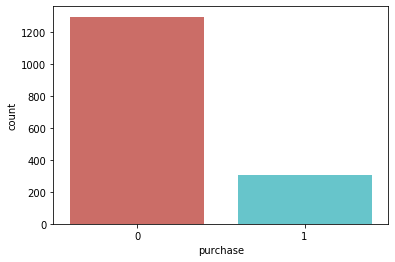


Percentages
-----------
Purchase:  19.125 %
No Purchase:  80.875 %


In [8]:
# counts of 0,1 in purchase
depcount = log1_data['purchase'].value_counts()
print('Counts of 0,1 in purchase variable')
print('----------------------------------')
print(depcount)

# bar chart to see distribution of dependent variable
print('')
print('Bar Chart of Purchase Counts')
sns.countplot(x = 'purchase', data = log1_data, palette = 'hls')
plt.show()

# find out percentage of each
count_no_pur = len(log1_data[log1_data['purchase'] == 0])
count_pur = len(log1_data[log1_data['purchase'] == 1])

pct_no_pur = count_no_pur/(count_no_pur + count_pur)
pct_pur = count_pur/(count_no_pur + count_pur)

print('')
print('Percentages')
print('-----------')
print('Purchase: ', pct_pur*100, '%')
print('No Purchase: ', pct_no_pur*100, '%')

#### Since there is a large imbalance between purchase and no purchase, the values should be balanced using Synthetic Minority Oversampling Technique (SMOTE).  SMOTE works by creating synthetic samples from the minor values instead of creating copies.  It randomly chooses one of the k-nearest-neighbors and creates similar, but randomly tweaked, new observations.  SMOTE will be used to up-sample No Purchase.

In [9]:
# create X and Y variables
X = pd.DataFrame(np.c_[log1_data['custid'], log1_data['month '], log1_data['spend'], log1_data['items'],
                       log1_data['discount_availed'], log1_data['product_return'], log1_data['month_elapsed'],
                       log1_data['catalog_sent'], log1_data['coupon_sent'], log1_data['items_todate'],
                       log1_data['spend_todate'], log1_data['catalog'], log1_data['store'], log1_data['web']], 
                       columns = ['custid', 'month ', 'spend', 'items', 'discount_availed', 'product_return', 'month_elapsed',
                                  'catalog_sent', 'coupon_sent', 'items_todate', 'spend_todate', 'catalog', 'store', 'web'])
Y = log1_data['purchase']

In [10]:
# setup SMOTE analysis from imblearn library
os = SMOTE(random_state = 0)

# split out training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
columns = X_train.columns

# fit SMOTE analysis
os_data_X, os_data_Y = os.fit_sample(X_train, Y_train)

# create dataframes from SMOTE analysis
os_data_X = pd.DataFrame(data = os_data_X, columns = columns)
os_data_Y = pd.DataFrame(data = os_data_Y, columns = ['purchase'])

# check the outcome to determine if the dependent variable became balanced
print('Length of Oversampled data is {}'.format(len(os_data_X)))
print('Number of No Purchase in Oversampled data is {}'.format(len(os_data_Y[os_data_Y['purchase'] == 0])))
print('Number of Purchase in Oversampled data is {}'.format(len(os_data_Y[os_data_Y['purchase'] == 1])))
print('Proportion of No Purchase data in Oversampled data is {}'.format(len(os_data_Y[os_data_Y['purchase'] == 0])/len(os_data_X)))
print('Proportion of Purchase data in Oversampled data is {}'.format(len(os_data_Y[os_data_Y['purchase'] == 1])/len(os_data_X)))

Length of Oversampled data is 1806
Number of No Purchase in Oversampled data is 903
Number of Purchase in Oversampled data is 903
Proportion of No Purchase data in Oversampled data is 0.5
Proportion of Purchase data in Oversampled data is 0.5


#### The data is now perfectly balanced, though for the supervised learning algorithm only the training data was oversampled, this was done to reduce the chance of information bleeding from the test data into the model training.
#### Next for the logisitic regression with the oversampled data, Recursive Feature Elimination (RFE) will be performed to determine the best or worst performing feature (independent variable).  The idea behind this is that RFE will select independent variables by recursively considering smaller and smaller sets of features.

In [11]:
# RFE data setup
log1_data_vars = log1_data.columns.values.tolist()
y_rfe = ['purchase']
x_rfe = [i for i in log1_data_vars if i not in y_rfe]

# set logistic regression model
logreg = LogisticRegression()

# perform RFE analysis with cross-validation to determine the best/best number of features to select
rfecv = RFECV(logreg, step = 1)
rfecv = rfecv.fit(os_data_X, os_data_Y.values.ravel())

print(rfecv.support_)
print(rfecv.ranking_)

[False False  True False False False  True  True False False False False
 False False]
[ 7  3  1  2  9 10  1  1  5  6 12 11  8  4]


#### After performing the RFE-CV analysis, the chosen parameters for the model will be *spend*, *items*, *month_elapsed*, *catalog_sent*.  These features appear to provide the best relationship with the target of purchasing decision.

In [12]:
# setup dataframe based on RFECV analysis
cols = ['spend', 'items', 'month_elapsed', 'catalog_sent']

X = os_data_X[cols]
Y = os_data_Y['purchase']

#### Logistic Regression model fitting

In [13]:
# split into testing and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

# define logistic regression
logreg = LogisticRegression()

# fit the model
logreg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
# predict the test set results of the logistic regression and calculating the accuracy
Y_pred = logreg.predict(X_test)

# print out the coefficients, standard errors, z scores, and p-values
# first append the intercept and the independents coefficients
params = np.append(logreg.intercept_,logreg.coef_[0])

# create a placeholder array to determine how many tests need to be done
newX = np.append(np.ones((len(X),1)), X, axis=1)

# calculate variance, standard errors, and t-test values
var_a = (np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_a = np.sqrt(var_a)
coefs = logreg.coef_[0]
z_a = params/sd_a
p_val_a = [stats.norm.sf(abs(x))*2 for x in z_a]

# create dictionary to cast to dataframe
log_results_dict = {'Independent Variables': ['Intercept', 'spend', 'items', 'month_elapsed', 'catalog_sent'],
                   'Coefficients': [logreg.intercept_[0], logreg.coef_[0][0], logreg.coef_[0][1], logreg.coef_[0][2], 
                                    logreg.coef_[0][3]], 'Standard Errors': [sd_a[0], sd_a[1], sd_a[2], sd_a[3], sd_a[4]],
                   'z': [z_a[0], z_a[1], z_a[2], z_a[3], z_a[4]], 'P > |z|': [p_val_a[0], p_val_a[1], p_val_a[2], p_val_a[3],
                                                                             p_val_a[4]]}

log_results = pd.DataFrame.from_dict(log_results_dict)
print('                     Logistic Regression Results')
print('---------------------------------------------------------------------------')
print(log_results)
print('---------------------------------------------------------------------------')
print('')
print('Accuracy of logistic regression on test set: {}'.format(logreg.score(X_test, Y_test)))

                     Logistic Regression Results
---------------------------------------------------------------------------
  Independent Variables  Coefficients  Standard Errors            z  \
0             Intercept     -3.421025         0.041846   -81.752309   
1                 spend      1.362418         0.000214  6369.208876   
2                 items      0.234307         0.019805    11.830533   
3         month_elapsed     -1.323174         0.008167  -162.013691   
4          catalog_sent     -0.587980         0.052965   -11.101342   

        P > |z|  
0  0.000000e+00  
1  0.000000e+00  
2  2.714122e-32  
3  0.000000e+00  
4  1.235747e-28  
---------------------------------------------------------------------------

Accuracy of logistic regression on test set: 1.0


#### After the results of the Logistic Regression are gathered, next a confusion matrix is created.  A confusion matrix is often used to describe the performance of a classification model.

In [15]:
# build confusion matrix from Y_test and Y_pred
cfm1 = confusion_matrix(Y_test, Y_pred)
print('Confusion Matrix')
print('----------------')
print(cfm1)

Confusion Matrix
----------------
[[289   0]
 [  0 253]]


#### According to this confusion matrix, the model had 289+253 = 542 correct predictions, and 0+0 = 0 incorrect predictions.
#### The next step is to compute precision, recall, F-measure, and support and build a Receiver Operating Characteristic (ROC) Curve.
- Precision is the ratio of true positives to the sum of true and false positives. The precision is the ability of the classifier to not label a negative sample as positive.
- Recall is the ratio of true positives to the sum of true positives and false negatives.  The recall is the ability of the classifier to find all the positive samples.
- The F-beta score is the weighted mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0. The F-beta score weights the recall more than the precision by a facter of beta. beta = 1.0 means recall and precision are equally important.
- Support is the number of occurrences of each class in Y_test.

In [16]:
# precision, recall, F-measure, and support table
print('                 Classification Report')
print('------------------------------------------------------')
print(classification_report(Y_test, Y_pred))
print('------------------------------------------------------')

                 Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       289
           1       1.00      1.00      1.00       253

    accuracy                           1.00       542
   macro avg       1.00      1.00      1.00       542
weighted avg       1.00      1.00      1.00       542

------------------------------------------------------


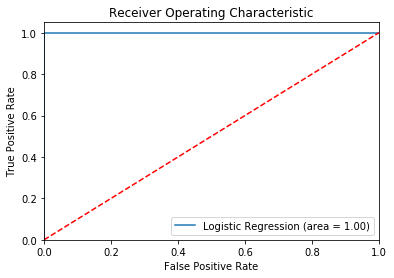

In [17]:
# ROC Curve
logit_roc_auc = roc_auc_score(Y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label = 'Logistic Regression (area = %0.2f)' %logit_roc_auc)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = "lower right")
plt.show()

#### The ROC Curve is a common tool used with binary classifiers such as logistic regression.  The dotted line represents the ROC curve of a purely random classifier; a good classifier remains as far from the dotted line as possible.  Given that the blue curve is the farthest it can be from the dotted line at every point, this model is extremely accurate.

## Linear Regression Question B:  Spending Behavior

In [18]:
# remove NaNs from dataset - linear regression should not have nulls within the target or features data columns
lin_data = data.copy()
lin_data = lin_data.dropna().reset_index(drop =  True)
lin_data = lin_data.drop(['purchase'], axis = 1)

# create empty columns
lin_data['catalog'] = np.nan
lin_data['store'] = np.nan
lin_data['web'] = np.nan

# fill columns with binary outcome
for i in range(0, len(lin_data)):
    if lin_data['channel_purchase'][i] == 'Catalog':
        lin_data['catalog'][i] = 1
    else:
        lin_data['catalog'][i] = 0
    
    if lin_data['channel_purchase'][i] == 'Store':
        lin_data['store'][i] = 1
    else:
        lin_data['store'][i] = 0
    
    if lin_data['channel_purchase'][i] == 'Web':
        lin_data['web'][i] = 1
    else:
        lin_data['web'][i] = 0


# drop channel_purchase column
lin_data = lin_data.drop(['channel_purchase'], axis = 1)

print(lin_data.head())
print('')
print("Null Check - Lin Reg Dataframe")
print("-------------------------------")
print(lin_data.isnull().sum())

   custid  month   spend  items  discount_availed  product_return  \
0       1       2  347.9    6.0               0.0             1.0   
1       1       3    6.0    1.0               0.0             0.0   
2       1      14  483.4    8.0              60.2             1.0   
3       2       1  182.0    1.0               3.0             0.0   
4       2       4   99.9    1.0               0.0             0.0   

   month_elapsed  catalog_sent  coupon_sent  items_todate  spend_todate  \
0              1             1            0             0           0.0   
1              0             1            0             6         347.9   
2             10             0            1             7         353.9   
3              0             1            1             0           0.0   
4              2             1            1             1         182.0   

   catalog  store  web  
0      0.0    1.0  0.0  
1      0.0    0.0  1.0  
2      0.0    1.0  0.0  
3      0.0    1.0  0.0  
4      1.

#### No nulls present from previous check, moving on to build density distribution to determine skewness of the data
#### Check skewness of the target (spend) data using Python's scipy library

Skewness: 6.401624747803519


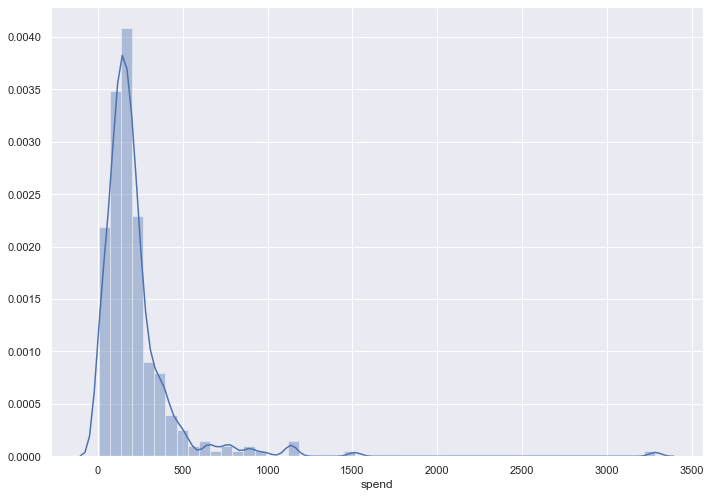

In [19]:
skewness = skew(lin_data['spend'])
print('Skewness: {}'.format(skewness))

## Data Visualization
# set the size of the figure
sns.set(rc = {'figure.figsize':(11.7, 8.27)})

# histogram showing the distribution of the target (spend) values
sns.distplot(lin_data['spend'], bins = 50)
plt.show()

#### The data is highly skewed, more specifically right skewed.  Data will have to be normalized, choosing to use Logarithm transformation because it is positively skewed data

In [20]:
# Create natural log transform of spend column
lin_data['spend_ln'] = np.log(lin_data['spend'])
print(lin_data.head())

   custid  month   spend  items  discount_availed  product_return  \
0       1       2  347.9    6.0               0.0             1.0   
1       1       3    6.0    1.0               0.0             0.0   
2       1      14  483.4    8.0              60.2             1.0   
3       2       1  182.0    1.0               3.0             0.0   
4       2       4   99.9    1.0               0.0             0.0   

   month_elapsed  catalog_sent  coupon_sent  items_todate  spend_todate  \
0              1             1            0             0           0.0   
1              0             1            0             6         347.9   
2             10             0            1             7         353.9   
3              0             1            1             0           0.0   
4              2             1            1             1         182.0   

   catalog  store  web  spend_ln  
0      0.0    1.0  0.0  5.851915  
1      0.0    0.0  1.0  1.791759  
2      0.0    1.0  0.0  6.180

### Check skewness and distribution again

Skewness of Ln: -0.9266659029182089


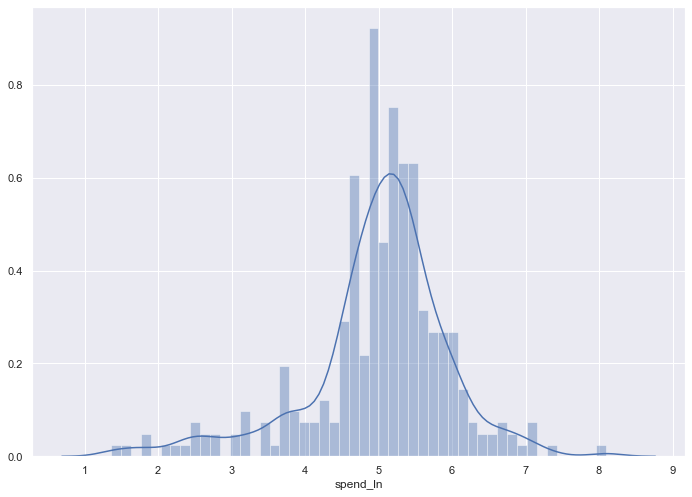

In [21]:
skewness = skew(lin_data['spend_ln'])
print('Skewness of Ln: {}'.format(skewness))

## Data Visualization
# set the size of the figure
sns.set(rc = {'figure.figsize':(11.7, 8.27)})

# histogram showing the distribution of the target (spend) values
sns.distplot(lin_data['spend_ln'], bins = 50)
plt.show()

#### The distribution is now mostly normalized, can proceed with the rest of the linear regression

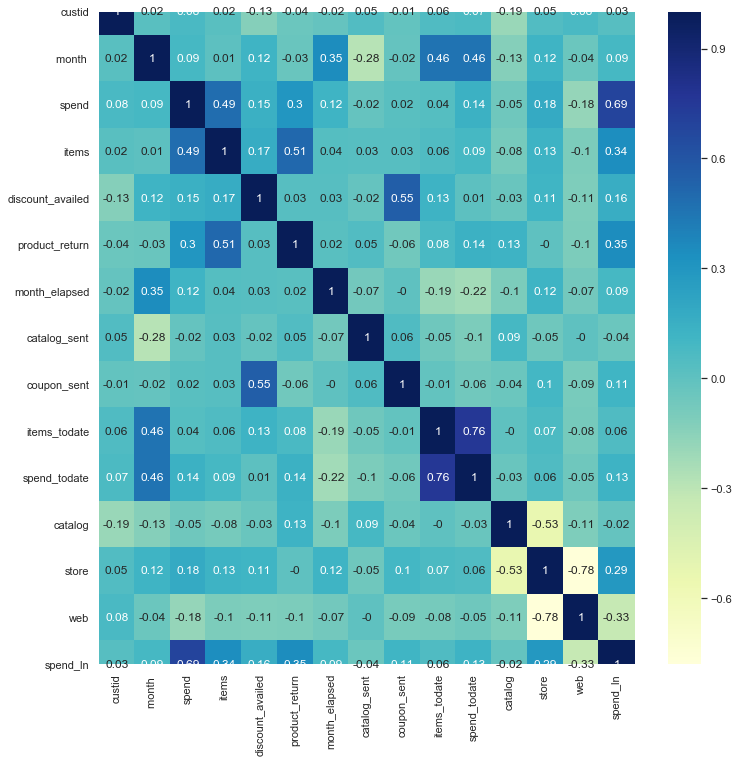

In [22]:
## Correlation Matrix
correlation_matrix = lin_data.corr().round(2)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(data = correlation_matrix, annot = True, ax = ax, cmap="YlGnBu")

#### Instead of using RFE for this linear regression, like was done with the Logistic Regression, the features (independent variables) will be selected based off the above correlation matrix, to showcase a concept learned in the Asynch.
#### From the correlation matrix above  *spend_ln* is more correlated to *month*, *spend*, *items*, *product_return*, *discount_availed*, *spend_todate*, and *coupon_sent*.  
#### Ignore *spend* and *spend_todate* since they are derivatives of *spend_ln*.
#### Ignore *coupon_sent* in order to avoid multi-colinearity with *discount_availed*
#### The model will be *spend_ln* as a function of *month*, *items*, *product_return*, and *discount_availed*
#### Plot *spend_ln* against the independent variables to determine the relationships, essentially get a categorical scatter plot for *product_return* since it's a binary variable.

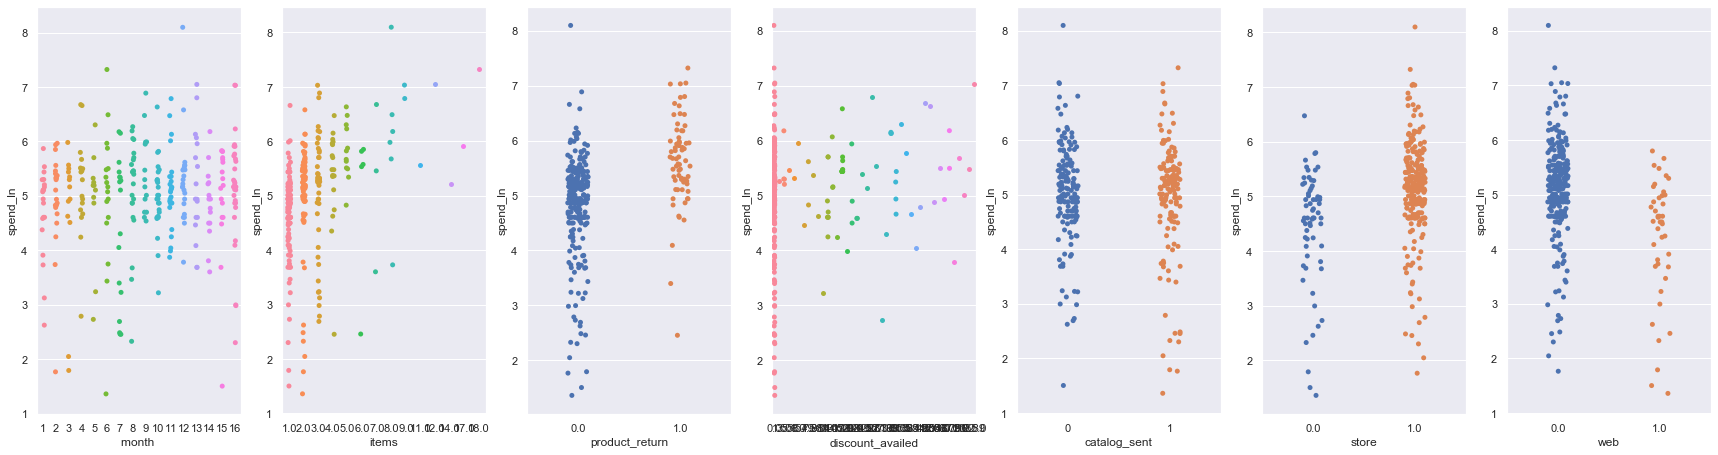

In [24]:
# set figure size
plt.figure(figsize = (30, 7.5))

# set features (independent variables)
features = ['month ', 'items', 'product_return', 'discount_availed', 'catalog_sent', 'store', 'web']

# set target (dependent variable)
target = lin_data['spend_ln']

# generate plots
for i, col in enumerate(features):
    plt.subplot(1, len(features), i + 1)
    x = lin_data[col]
    y = target
    sns.stripplot(x, y, jitter = True)

#### Now ready to prepare the data for training in the supervised learning environment

In [25]:
# create x and y variables for the regression model, the X variables are the independent variables (features) defined above
# the Y variable is the target or dependent variable
Xr = pd.DataFrame(np.c_[lin_data['month '], lin_data['items'], lin_data['product_return'],
                        lin_data['discount_availed'], lin_data['catalog_sent'], lin_data['store'], lin_data['web']], 
                 columns = ['month ', 'items', 'product_return', 'discount_availed', 'catalog_sent', 'store', 'web'])
Yr = lin_data['spend_ln']

In [26]:
# splits the training and test data set in 80% : 20%
# assign random_state to any value.This ensures consistency.
Xr_train, Xr_test, Yr_train, Yr_test = train_test_split(Xr, Yr, test_size = 0.3, random_state=5)
print(Xr_train.shape)
print(Xr_test.shape)
print(Yr_train.shape)
print(Yr_test.shape)

(214, 7)
(92, 7)
(214,)
(92,)


In [27]:
# train the model using scikit-learn's LinearRegression function
lin_model = LinearRegression()
lin_model.fit(Xr_train, Yr_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [28]:
# evaluate the model on the training set
yr_train_predict = lin_model.predict(Xr_train)
rmse = (np.sqrt(mean_squared_error(Yr_train, yr_train_predict)))
r2 = r2_score(Yr_train, yr_train_predict)

print('Training set model performance')
print('------------------------------')
print('Training RMSE: {}'.format(rmse))
print('Training R2: {}'.format(r2))

# evaluate the model on the testing set
yr_test_predict = lin_model.predict(Xr_test)
# root mean square error for the testing set
rmse_test = (np.sqrt(mean_squared_error(Yr_test, yr_test_predict)))
# r-squared value for the testing set
r2_test = r2_score(Yr_test, yr_test_predict)
# mean absolute error for testing set
mae_test = mean_absolute_error(Yr_test, yr_test_predict)

print('')
print('Testing set model performance')
print('-----------------------------')
print('Testing RMSE: {}'.format(rmse_test))
print('Testing R2: {}'.format(r2_test))
print('Testing MAE: {}'.format(mae_test))

# perform tests of significance against the model
# first append the intercept and the independents coefficients
params = np.append(lin_model.intercept_,lin_model.coef_)

# create a placeholder array to determine how many tests need to be done
newXr = np.append(np.ones((len(Xr),1)), Xr, axis=1)

# calculate mean sampling error
MSE = (sum((Yr_test-yr_test_predict)**2))/(len(newXr)-len(newXr[0]))

# calculate variance, standard errors, and t-test values
var_b = MSE*(np.linalg.inv(np.dot(newXr.T,newXr)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/sd_b

# calculate p-values
p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

# round standard errors and t-test outputs
sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)

# output results to dictionary and then transform into dataframe
lin_results_dict = {'Independent Variables': ['Intercept', 'Month', 'Items', 'Product_Return', 'Discount_Availed',
                                              'Catalog Sent', 'Store', 'Web'],
                    'Coefficients': [lin_model.intercept_, lin_model.coef_[0], lin_model.coef_[1], lin_model.coef_[2],
                                     lin_model.coef_[3], lin_model.coef_[4], lin_model.coef_[5], lin_model.coef_[6]],
                    'Standard Errors': [sd_b[0], sd_b[1], sd_b[2], sd_b[3], sd_b[4], sd_b[5], sd_b[6], sd_b[7]],
                    't values': [ts_b[0], ts_b[1], ts_b[2], ts_b[3], ts_b[4], ts_b[5], ts_b[6], ts_b[7]],
                    'Probabilities': [p_values[0], p_values[1], p_values[2], p_values[3], p_values[4], p_values[5],
                                      p_values[6], p_values[7]]}
lin_results = pd.DataFrame.from_dict(lin_results_dict)

# print the results for easy to read analysis
print('')
print('                     Linear Regression Results')
print('--------------------------------------------------------------------')
print(lin_results)
print('--------------------------------------------------------------------')
print('')
print('Model Accuracy')
print('--------------')
print('RMSE: {}'.format(rmse_test))
print('R2: {}'.format(r2_test))
print('MAE: {}'.format(mae_test))

Training set model performance
------------------------------
Training RMSE: 0.8407523108861539
Training R2: 0.24815864975074586

Testing set model performance
-----------------------------
Testing RMSE: 0.7982762627628105
Testing R2: 0.2722610411994051
Testing MAE: 0.5860573961632803

                     Linear Regression Results
--------------------------------------------------------------------
  Independent Variables  Coefficients  Standard Errors  t values  \
0             Intercept      4.471374            0.115    38.773   
1                 Month      0.017377            0.006     3.026   
2                 Items      0.070298            0.013     5.235   
3        Product_Return      0.591100            0.073     8.139   
4      Discount_Availed      0.004873            0.002     3.175   
5          Catalog Sent     -0.148408            0.053    -2.791   
6                 Store      0.194524            0.104     1.865   
7                   Web     -0.564820            0.12

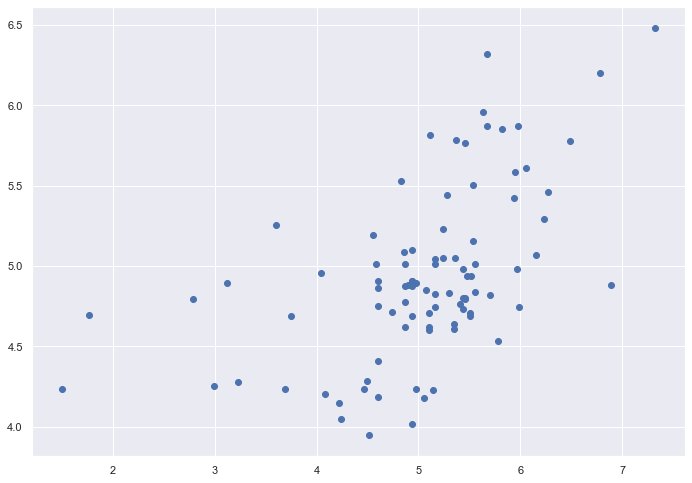

In [29]:
# plot Y_test vs Y_pred
# a straight line indicates an ideal model, everthing else
# look at the MAE and RMSE to determine model accuracy
plt.scatter(Yr_test, yr_test_predict)
plt.show()

## Logistic Regression Question C:  Decision to Return a Purchased Product

#### We will follow the same steps for the Logistic Regression in Question A.  Though these will be different models, the steps will be the same to ensure consistency in model creation, so any differences are due to the data and not the procedure.

In [30]:
# Dataframe Creation
# create binary variables
log2_data = data.copy()

# create empty columns
log2_data['catalog'] = np.nan
log2_data['store'] = np.nan
log2_data['web'] = np.nan

# fill columns with binary outcome
for i in range(0, len(log2_data)):
    if log2_data['channel_purchase'][i] == 'Catalog':
        log2_data['catalog'][i] = 1
    else:
        log2_data['catalog'][i] = 0
    
    if log2_data['channel_purchase'][i] == 'Store':
        log2_data['store'][i] = 1
    else:
        log2_data['store'][i] = 0
    
    if log2_data['channel_purchase'][i] == 'Web':
        log2_data['web'][i] = 1
    else:
        log2_data['web'][i] = 0

# drop channel_purchase column
log2_data = log2_data.drop(['channel_purchase'], axis = 1)
        
# fill in NaN on discount_availed, product_return, spend, items with 0
columns = ['spend', 'items', 'discount_availed', 'product_return']

for cols in columns:
    log2_data[cols] = log2_data[cols].fillna(0)

print(log2_data.head())

   custid  month   purchase  spend  items  discount_availed  product_return  \
0       1       1         0    0.0    0.0               0.0             0.0   
1       1       2         1  347.9    6.0               0.0             1.0   
2       1       3         1    6.0    1.0               0.0             0.0   
3       1       4         0    0.0    0.0               0.0             0.0   
4       1       5         0    0.0    0.0               0.0             0.0   

   month_elapsed  catalog_sent  coupon_sent  items_todate  spend_todate  \
0              0             0            0             0           0.0   
1              1             1            0             0           0.0   
2              0             1            0             6         347.9   
3              0             1            0             7         353.9   
4              1             1            1             7         353.9   

   catalog  store  web  
0      0.0    0.0  0.0  
1      0.0    1.0  0.0  

Counts of 0,1 in product_return variable
----------------------------------------
0.0    1532
1.0      68
Name: product_return, dtype: int64

Bar Chart of Product_Return Counts


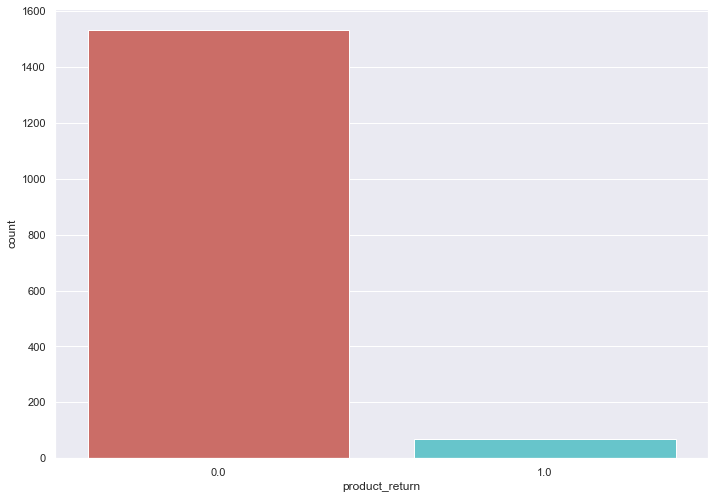


Percentages
-----------
Return:  4.25 %
No Return:  95.75 %


In [31]:
# Data Exploration
# counts of 0,1 in purchase
depcount = log2_data['product_return'].value_counts()
print('Counts of 0,1 in product_return variable')
print('----------------------------------------')
print(depcount)

# bar chart to see distribution of dependent variable
print('')
print('Bar Chart of Product_Return Counts')
sns.countplot(x = 'product_return', data = log2_data, palette = 'hls')
plt.show()

# find out percentage of each
count_no_ret = len(log2_data[log2_data['product_return'] == 0])
count_ret = len(log2_data[log2_data['product_return'] == 1])

pct_no_ret = count_no_ret/(count_no_ret + count_ret)
pct_ret = count_ret/(count_no_ret + count_ret)

print('')
print('Percentages')
print('-----------')
print('Return: ', pct_ret*100, '%')
print('No Return: ', pct_no_ret*100, '%')

In [32]:
# create X and Y variables
Xl = pd.DataFrame(np.c_[log2_data['custid'], log2_data['month '], log2_data['spend'], log2_data['items'],
                       log2_data['discount_availed'], log2_data['purchase'], log2_data['month_elapsed'],
                       log2_data['catalog_sent'], log2_data['coupon_sent'], log2_data['items_todate'],
                       log2_data['spend_todate'], log2_data['catalog'], log2_data['store'], log2_data['web']], 
                       columns = ['custid', 'month ', 'spend', 'items', 'discount_availed', 'purchase', 'month_elapsed',
                                  'catalog_sent', 'coupon_sent', 'items_todate', 'spend_todate', 'catalog', 'store', 'web'])
Yl = log2_data['product_return']

In [33]:
# setup SMOTE analysis from imblearn library
os2 = SMOTE(random_state = 0)

# split out training and testing data
Xl_train, Xl_test, Yl_train, Yl_test = train_test_split(Xl, Yl, test_size = 0.3, random_state = 0)
columns = Xl_train.columns

# fit SMOTE analysis
os_data_Xl, os_data_Yl = os2.fit_sample(Xl_train, Yl_train)

# create dataframes from SMOTE analysis
os_data_Xl = pd.DataFrame(data = os_data_Xl, columns = columns)
os_data_Yl = pd.DataFrame(data = os_data_Yl, columns = ['product_return'])

# check the outcome to determine if the dependent variable became balanced
print('Length of Oversampled data is {}'.format(len(os_data_Xl)))
print('Number of No Return in Oversampled data is {}'.format(len(os_data_Yl[os_data_Yl['product_return'] == 0])))
print('Number of Return in Oversampled data is {}'.format(len(os_data_Yl[os_data_Yl['product_return'] == 1])))
print('Proportion of No Return data in Oversampled data is {}'.format(len(os_data_Yl[os_data_Yl['product_return'] == 0])/len(os_data_Xl)))
print('Proportion of Return data in Oversampled data is {}'.format(len(os_data_Yl[os_data_Yl['product_return'] == 1])/len(os_data_Xl)))

Length of Oversampled data is 2146
Number of No Return in Oversampled data is 1073
Number of Return in Oversampled data is 1073
Proportion of No Return data in Oversampled data is 0.5
Proportion of Return data in Oversampled data is 0.5


In [34]:
# RFE data setup
log2_data_vars = log2_data.columns.values.tolist()
yl_rfe = ['product_return']
xl_rfe = [i for i in log2_data_vars if i not in yl_rfe]

# set logistic regression model
logreg = LogisticRegression()

# perform RFE analysis with cross-validation to determine the best/best number of features to select
rfecv = RFECV(logreg, step = 1)
rfecv = rfecv.fit(os_data_Xl, os_data_Yl.values.ravel())

print(rfecv.support_)
print(rfecv.ranking_)

[ True  True False  True  True  True  True  True  True  True False  True
  True  True]
[1 1 2 1 1 1 1 1 1 1 3 1 1 1]


In [35]:
# setup dataframe based on RFECV analysis
cols = ['spend', 'items', 'discount_availed', 'month_elapsed', 'items_todate', 'spend_todate', 'catalog', 'store',
        'web']

Xl = os_data_Xl[cols]
Yl = os_data_Yl['product_return']

In [36]:
# split into testing and training
Xl_train, Xl_test, Yl_train, Yl_test = train_test_split(Xl, Yl, test_size = 0.3, random_state = 0)

# define logistic regression
logreg2 = LogisticRegression()

# fit the model
logreg2.fit(Xl_train, Yl_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
# predict the test set results of the logistic regression and calculating the accuracy
Yl_pred = logreg2.predict(Xl_test)

# print out the coefficients, standard errors, z scores, and p-values
# first append the intercept and the independents coefficients
paramsl = np.append(logreg2.intercept_,logreg2.coef_[0])

# create a placeholder array to determine how many tests need to be done
newXl = np.append(np.ones((len(Xl),1)), Xl, axis=1)

# calculate variance, standard errors, and t-test values
var_c = (np.linalg.inv(np.dot(newXl.T,newXl)).diagonal())
sd_c = np.sqrt(var_c)
coefsl = logreg2.coef_[0]
z_c = paramsl/sd_c
p_val_c = [stats.norm.sf(abs(x))*2 for x in z_c]

# create dictionary to cast to dataframe
log2_results_dict = {'Independent Variables': ['Intercept', 'spend', 'items', 'discount_availed', 'month_elapsed',
                                               'items_todate', 'spend_todate', 'catalog', 'store', 'web'],
                     'Coefficients': [logreg2.intercept_[0], logreg2.coef_[0][0], logreg2.coef_[0][1],
                                      logreg2.coef_[0][2], logreg2.coef_[0][3], logreg2.coef_[0][4],
                                      logreg2.coef_[0][5], logreg2.coef_[0][6], logreg2.coef_[0][7],
                                      logreg2.coef_[0][8]],
                     'Standard Errors': [sd_c[0], sd_c[1], sd_c[2], sd_c[3], sd_c[4], sd_c[5], sd_c[6], sd_c[7],
                                         sd_c[8], sd_c[9]],
                     'z': [z_c[0], z_c[1], z_c[2], z_c[3], z_c[4], z_c[5], z_c[6], z_c[7], z_c[8], z_c[9]],
                     'P > |z|': [p_val_c[0], p_val_c[1], p_val_c[2], p_val_c[3], p_val_c[4], p_val_c[5], p_val_c[6],
                                 p_val_c[7], p_val_c[8], p_val_c[9]]}

log2_results = pd.DataFrame.from_dict(log2_results_dict)
print('                     Logistic Regression Results')
print('---------------------------------------------------------------------------')
print(log2_results)
print('---------------------------------------------------------------------------')
print('')
print('Accuracy of logistic regression on test set: {}'.format(logreg2.score(Xl_test, Yl_test)))

                     Logistic Regression Results
---------------------------------------------------------------------------
  Independent Variables  Coefficients  Standard Errors           z  \
0             Intercept     -3.606137         0.045845  -78.659379   
1                 spend      0.006105         0.000163   37.381884   
2                 items      1.611111         0.010470  153.885230   
3      discount_availed     -0.099495         0.001624  -61.265037   
4         month_elapsed     -0.064527         0.007787   -8.286173   
5          items_todate      0.172741         0.009761   17.697061   
6          spend_todate     -0.005107         0.000113  -45.112092   
7               catalog      3.186736         0.119563   26.653112   
8                 store      1.023057         0.074943   13.651179   
9                   web      0.802426         0.119628    6.707685   

         P > |z|  
0   0.000000e+00  
1  7.696160e-306  
2   0.000000e+00  
3   0.000000e+00  
4   1.169

In [38]:
# build confusion matrix from Y_test and Y_pred
cfm2 = confusion_matrix(Yl_test, Yl_pred)
print('Confusion Matrix')
print('----------------')
print(cfm2)

Confusion Matrix
----------------
[[298  26]
 [  9 311]]


#### Confusion Matrix shows that the model probably got 609 correct and missed 35

In [39]:
# precision, recall, F-measure, and support table
print('                 Classification Report')
print('------------------------------------------------------')
print(classification_report(Yl_test, Yl_pred))
print('------------------------------------------------------')

                 Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94       324
         1.0       0.92      0.97      0.95       320

    accuracy                           0.95       644
   macro avg       0.95      0.95      0.95       644
weighted avg       0.95      0.95      0.95       644

------------------------------------------------------


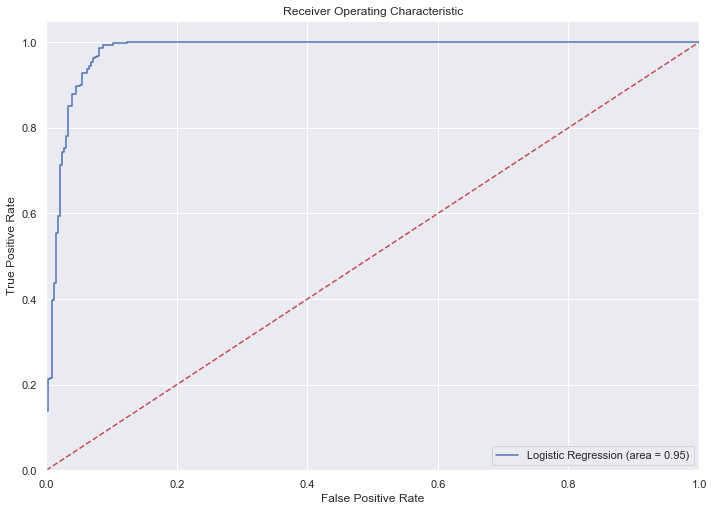

In [40]:
# ROC Curve
logit2_roc_auc = roc_auc_score(Yl_test, logreg2.predict(Xl_test))
fpr2, tpr2, thresholds2 = roc_curve(Yl_test, logreg2.predict_proba(Xl_test)[:,1])
plt.figure()
plt.plot(fpr2, tpr2, label = 'Logistic Regression (area = %0.2f)' %logit2_roc_auc)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = "lower right")
plt.show()